In [1]:
!pip install kaggle

In [2]:
!pip install plotly

In [3]:
from transformers import pipeline
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
import re
from datetime import datetime
import numpy as np

In [4]:
# ID file
file_id = "1-5_JXOnscS2zN1nEgNVKJX5wFL4uLb1L"
download_link = f"https://drive.google.com/uc?id={file_id}"

# dowload the file csv from Google drive
response = requests.get(download_link)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data, encoding='utf-8')

In [5]:
# data wraining
df.set_index('Unnamed: 0', inplace=True)
df.index.name ="ID"

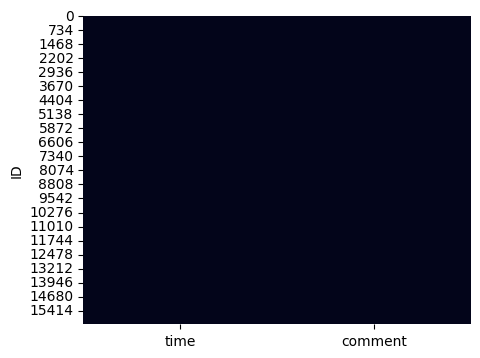

In [6]:
# there don´t present data null
plt.figure(figsize=(5, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [7]:
# Load analitic model for feelings
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
# Create function for get polarity in comments
def obtener_polaridad(comentario):
    resultado = classifier(comentario)
    return resultado[0]['label']

In [9]:
# apply the function to each comment of dataframe.
df['polarity'] = df['comment'].apply(obtener_polaridad)

In [10]:
# df de contigencia
df_origin = df.copy()

In [11]:
df=df_origin.copy()

In [12]:
# function for create regular expression
def extraer_numeros(texto):
    numeros = re.findall(r'\d+', texto)
    return int(numeros[0]) if numeros else None
df['score'] = df['polarity'].apply(extraer_numeros)

In [13]:
def positive(puntuacion):
    return 1 if puntuacion in [4, 5] else 0
df['POSITIVE'] = df['score'].apply(positive)


def neutral(puntuacion):
    return 1 if puntuacion in [3] else 0
df['NEUTRAL'] = df['score'].apply(neutral)


def negative(puntuacion):
    return 1 if puntuacion in [1, 2] else 0
df['NEGATIVE'] = df['score'].apply(negative)


In [14]:
#separamos los acumulados, para aplicar luego.
#df['CUMULATIVE_POSITIVE'] = df['POSITIVE'].cumsum()
#df['CUMULATIVE_NEUTRAL'] = df['NEUTRAL'].cumsum()
#df['CUMULATIVE_NEGATIVE'] = df['NEGATIVE'].cumsum()

In [15]:
df=df[['time', 'POSITIVE', 'NEUTRAL', 'NEGATIVE']]

In [16]:
df['time'] = df['time'].astype(str)

# Ahora puedes realizar el groupby
group_df = df.groupby('time').agg({
    'POSITIVE': 'sum',
    'NEUTRAL': 'sum',
    'NEGATIVE': 'sum'
}).reset_index()

<ipython-input-16-c9cee24fa6bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['time'].astype(str)


In [17]:
df1=group_df.copy()

In [18]:
df1 = df1.sort_values(by="time", ascending=True)

In [19]:
df1["time"] = df1["time"].astype(str)

In [20]:
# Suponiendo que tienes un DataFrame llamado df1 y la columna es "time"
# Modificar valores utilizando expresiones regulares
df1["tiempo"] = df1["time"].apply(lambda x: re.sub(r'24:00', '00:00', x))

# Convertir a objetos datetime
df1["tiempo"] = pd.to_datetime(df1["time"], errors='coerce')


In [21]:
df1["tiempo"].isna().sum()

1821

## DATAFRAME CON DEFECTUOSOS
Se supone que el timpo va de 00:03 a 10 minutos

In [22]:
filas_nat=df1[df1["tiempo"].isna()]

In [23]:
filas_nat.head(3)

,time,POSITIVE,NEUTRAL,NEGATIVE,tiempo
3692,24:00,2,0,0,NaT
3693,24:01,1,0,1,NaT
3694,24:02,1,0,1,NaT


## ELIMINAMOS ANOMALIA

In [24]:
df1 = df1.dropna(subset=["tiempo"])

In [25]:
df1 = df1.sort_values(by="tiempo", ascending=True)

In [26]:
df1["tiempo"].isna().sum()

0

In [27]:
df1=df1[['tiempo', 'POSITIVE', 'NEUTRAL', 'NEGATIVE']]

In [28]:
# transformacion para  trasladar los minutos a segundos
df1["tiempo"] = pd.to_datetime(df1["tiempo"], errors='coerce')

# Formatear la columna "tiempo" en el nuevo formato sin ceros a la derecha y sin el último ":"
df1["tiempo"] = df1["tiempo"].dt.strftime('%H:%M:%S').str.rstrip("0").str[:-1]

In [29]:
df1['tiempo'] = df1['tiempo'].astype(str)

## merge

In [30]:
# Crear un rango de tiempo desde el segundo 3 hasta el minuto 23:59
tiempo_range = pd.date_range(start="00:00:03", end="00:23:59", freq='S')

# Crear un DataFrame con la columna "tiempo"
df2 = pd.DataFrame({'tiempo': tiempo_range})

# Convertir la columna "tiempo" a objetos datetime
df2['tiempo'] = pd.to_datetime(df2['tiempo'])

# Extraer minutos y segundos de la columna "tiempo"
df2['tiempo'] = df2['tiempo'].dt.strftime('%M:%S')

# Transformamos los datos a sts
df2['tiempo'] = df2['tiempo'].astype(str)

In [31]:
# aplicamos funcion para mergear
def merge_and_add_data(row, df):
    tiempo_value = row['tiempo']
    matching_data = df1[df1['tiempo'] == tiempo_value][['POSITIVE', 'NEUTRAL', 'NEGATIVE']]
    return matching_data.values[0] if not matching_data.empty else [0, 0, 0]

In [32]:
# Aplicar la función usando apply y una función lambda
merged_data = df2.apply(lambda row: merge_and_add_data(row, df), axis=1, result_type='expand')
df2[['POSITIVE', 'NEUTRAL', 'NEGATIVE']] = merged_data

In [33]:
df2['CUMULATIVE_POSITIVE'] = df2['POSITIVE'].cumsum()
df2['CUMULATIVE_NEUTRAL'] = df2['NEUTRAL'].cumsum()
df2['CUMULATIVE_NEGATIVE'] = df2['NEGATIVE'].cumsum()

In [34]:
df_positive = df2[['tiempo', 'CUMULATIVE_POSITIVE']]
df_positive = df_positive.rename(columns={'CUMULATIVE_POSITIVE': 'y'})

In [35]:
df_neutral = df2[['tiempo', 'CUMULATIVE_NEUTRAL']]
df_neutral = df_neutral.rename(columns={'CUMULATIVE_NEUTRAL': 'y'})

In [36]:
df_negative = df2[['tiempo', 'CUMULATIVE_NEGATIVE']]
df_negative = df_negative.rename(columns={'CUMULATIVE_NEGATIVE': 'y'})

## GRAFICO ESTATICO

In [37]:
import pandas as pd
import plotly.express as px

# Asignar colores a cada categoría al crear los DataFrames
color_mapping = {'POSITIVE': 'green', 'NEUTRAL': 'white', 'NEGATIVE': 'red'}

df_positive['color'] = color_mapping['POSITIVE']
df_neutral['color'] = color_mapping['NEUTRAL']
df_negative['color'] = color_mapping['NEGATIVE']

# Concatenar los conjuntos de datos
df = pd.concat([df_positive, df_neutral, df_negative], keys=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

# Crear el gráfico estático
fig_total = px.line(df, x='tiempo', y='y', color='color', range_x=[0, 6], range_y=[0, 3],
                    line_dash='color', color_discrete_sequence=['green', 'white', 'red'])

# Personalizar la gráfica total
fig_total.update_layout(
    title='Trayectorias del Recorrido Total',
    xaxis_title='time',
    yaxis_title='number of sentences',
    template='plotly_dark',
    xaxis=dict(showgrid=True, gridcolor='rgba(255, 255, 255, 0.1)'),
    yaxis=dict(showgrid=True, gridcolor='rgba(255, 255, 255, 0.1)'),
    height=800,
    width=1600
)

# Mostrar el gráfico estático
fig_total.show()


##GRAFICO DINAMICO

In [38]:
df_positive.head()

,tiempo,y,color
0,00:03,0,green
1,00:04,0,green
2,00:05,1,green
3,00:06,1,green
4,00:07,2,green


In [39]:
df_positive.shape

(1437, 3)

In [63]:
df11=pd.DataFrame({
    "Tiempo": df_positive["tiempo"],
    "Acumulado": df_positive["y"] ,
})
df11['x'] = 1.5
df11['y'] = 8

In [64]:
df22=pd.DataFrame({
    "Tiempo": df_neutral["tiempo"],
    "Acumulado": df_neutral["y"] ,
})
df22['x'] = 2
df22['y'] = 4

In [67]:
df33=pd.DataFrame({
    "Tiempo": df_negative["tiempo"],
    "Acumulado": df_negative["y"] ,
})
df33['x'] = 2.5
df33['y'] = 9

In [69]:

# Agregar columnas de colores y símbolos específicos
df11['Color'] = 'green'
df11['Symbol'] = 'circle'
df22['Color'] = 'grey'
df22['Symbol'] = 'circle'
df33['Color'] = 'red'
df33['Symbol'] = 'circle'

# Concatenar los conjuntos de datos
df = pd.concat([df11, df22, df33], keys=['Conjunto1', 'Conjunto2', 'Conjunto3'])

# Crear la gráfica animada con tamaño variable y colores personalizados
fig = px.scatter(df, x='x', y='y', animation_frame='Tiempo', size='Acumulado',
                 color='Color', range_x=[0, 4], range_y=[0, 4], size_max=250,
                 color_discrete_map={'red': 'red', 'green': 'green', 'blue': 'blue'}, symbol='Symbol', text='Acumulado')

# Personalizar la animación y el diseño
fig.update_layout(
    title='EVOLUTION OF COMMENTS',
    template='plotly_dark',  # Cambiar al tema oscuro
    xaxis=dict(showgrid=False),  # Quitar la cuadrícula del eje X
    yaxis=dict(showgrid=False),  # Quitar la cuadrícula del eje Y
    height=900  # Ajustar la altura del lienzo
)

# Mostrar la gráfica
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [70]:
import pandas as pd
import plotly.express as px

# Supongamos que los DataFrames df11, df22, df33 ya están definidos

# Agregar columnas de colores y símbolos específicos
df11['Color'] = 'green'
df11['Symbol'] = 'circle'
df22['Color'] = 'white'  # Cambiar de 'grey' a 'white'
df22['Symbol'] = 'circle'
df33['Color'] = 'red'
df33['Symbol'] = 'circle'

# Concatenar los conjuntos de datos
df = pd.concat([df11, df22, df33], keys=['Conjunto1', 'Conjunto2', 'Conjunto3'])

# Crear la gráfica animada con tamaño variable y colores personalizados
fig = px.scatter(df, x='x', y='y', animation_frame='Tiempo', size='Acumulado',
                 color='Color', range_x=[0, 4], range_y=[0, 4], size_max=250,
                 color_discrete_map={'red': 'red', 'green': 'green', 'white': 'white'}, symbol='Symbol', text='Acumulado')

# Personalizar la animación y el diseño
fig.update_layout(
    title='EVOLUTION OF COMMENTS',
    template='plotly_dark',  # Cambiar al tema oscuro
    xaxis=dict(showgrid=False),  # Quitar la cuadrícula del eje X
    yaxis=dict(showgrid=False),  # Quitar la cuadrícula del eje Y
    height=900  # Ajustar la altura del lienzo
)

# Mostrar la gráfica
fig.show()


Output hidden; open in https://colab.research.google.com to view.